In [ ]:
import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import random
import pandas as pd


Configuration

In [ ]:
BASE_URL = "https://www.amazon.in/s"
QUERY = "playstation"
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/124.0.0.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
}

Session with retries

In [ ]:
session= requests.Session()
retry = Retry(connect=3,backoff_factor=1,status_forcelist=[429,500,502,503,504])
adapter = HTTPAdapter(max_retries=retry)
session.mount("http://",adapter)
session.mount("https://",adapter)

Scraping logic

In [ ]:
all_data = []

for page in range(1,20):
  params = {'k': QUERY, 'page': page}
  print(f'scraping page {page}...')

  try:
    response = session.get(BASE_URL, params=params, headers=HEADERS, timeout=10)
    response.raise_for_status()
  except requests.RequestException as e:
    print(f'Error on page {page}: {e}')
    continue

  soup = BeautifulSoup(response.text, 'html.parser')

  # Extract product information for the current page
  for result in soup.find_all('div', {'data-component-type': 's-search-result'}):
    ProductName_tag = result.find('a', {'class':'a-link-normal s-line-clamp-2 s-line-clamp-3-for-col-12 s-link-style a-text-normal'})
    ProductPrice_tag = result.find('span', class_='a-price-whole')
    ProductRating_tag = result.find('span', class_='a-icon-alt')
    ProductNoOfReviews = result.find('span', class_='a-size-mini puis-normal-weight-text s-underline-text')

    ProductName = ProductName_tag.get_text(strip=True) if ProductName_tag else None
    ProductPrice = ProductPrice_tag.get_text(strip=True) if ProductPrice_tag else None
    ProductRating = ProductRating_tag.get_text(strip=True) if ProductRating_tag else None
    productNoOfReview = ProductNoOfReviews.get_text(strip=True) if ProductNoOfReviews else None


    all_data.append({
        "ProductName": ProductName,
        "ProductPrice": ProductPrice,
        "ProductRating": ProductRating,
        "ProductNoOfReview": productNoOfReview})
  #delay
  time.sleep(random.uniform(2, 5))

print(f"✅ Scraped {len(all_data)} products total")

scraping page 1...
scraping page 2...
scraping page 3...
scraping page 4...
scraping page 5...
scraping page 6...
scraping page 7...
scraping page 8...
scraping page 9...
scraping page 10...
scraping page 11...
scraping page 12...
scraping page 13...
scraping page 14...
scraping page 15...
scraping page 16...
scraping page 17...
scraping page 18...
scraping page 19...
✅ Scraped 304 products total


In [ ]:
df = pd.DataFrame(all_data)
display(df.head())

,ProductName,ProductPrice,ProductRating,ProductNoOfReview
0,Sony PlayStation5 Gaming Console (Slim),"54,989",4.6 out of 5 stars,(774)
1,Sony PlayStation®5 Digital Edition (slim) Cons...,"49,990",4.6 out of 5 stars,(590)
2,Rs.1000 Sony PlayStation Store Gift Card (Emai...,"1,000",4.4 out of 5 stars,(5.8K)
3,Sony PlayStation Portal Remote Player,"18,990",4.4 out of 5 stars,(115)
4,Sony DualSense Wireless Controller White (Play...,"5,894",4.1 out of 5 stars,(3.9K)


In [ ]:
df.to_csv("playstation.csv")

**DATA CLEANING**

In [ ]:
df["ProductRating"] = (df["ProductRating"].astype(str).str.extract(r"([\d.]+)").astype(float))

In [ ]:
df

,ProductName,ProductPrice,ProductRating,ProductNoOfReview
0,Sony PlayStation5 Gaming Console (Slim),"54,989",4.6,(774)
1,Sony PlayStation®5 Digital Edition (slim) Cons...,"49,990",4.6,(590)
2,Rs.1000 Sony PlayStation Store Gift Card (Emai...,"1,000",4.4,(5.8K)
3,Sony PlayStation Portal Remote Player,"18,990",4.4,(115)
4,Sony DualSense Wireless Controller White (Play...,"5,894",4.1,(3.9K)
...,...,...,...,...
311,Dual Controller Stand – Universal Gamepad Hold...,389,3.9,(5)
312,Assassin's Creed Valhalla Drakkar Edition (Fre...,"1,565",4.1,(539)
313,GADGETS WRAP Printed Vinyl Decal Sticker Skin ...,246,NaN,None
314,Glitch | Ps5 Dust Cover | Covers For Playstati...,499,4.4,(399)


In [ ]:
df = df.rename(columns={'ProductNoOfReview': 'Reviews'})

In [ ]:
df["ProductPrice"] = (df["ProductPrice"].astype(str).replace('[₹, ]', '', regex=True).replace('', None).apply(pd.to_numeric, errors='coerce').astype("Int64"))


def clean_reviews(x):
    if pd.isna(x):
        return None
    x = str(x).strip("()").replace(",", "").strip()
    if x.lower() == "none" or x == "":
        return None
    if "K" in x:
        return int(float(x.replace("K", "")) * 1000)
    elif "M" in x:
        return int(float(x.replace("M", "")) * 1_000_000)
    else:
        try:
            return int(float(x))
        except:
            return None

df["Reviews"] = df["Reviews"].apply(clean_reviews).astype("Int64")

# Ensure 'Rating_Out_of_5' is float
df["ProductRating"] = df["ProductRating"].astype(float)

# Check types and sample output
print(df.dtypes)
print(df.head())


ProductName       object
ProductPrice       Int64
ProductRating    float64
Reviews            Int64
dtype: object
                                         ProductName  ProductPrice  \
0            Sony PlayStation5 Gaming Console (Slim)         54989   
1  Sony PlayStation®5 Digital Edition (slim) Cons...         49990   
2  Rs.1000 Sony PlayStation Store Gift Card (Emai...          1000   
3              Sony PlayStation Portal Remote Player         18990   
4  Sony DualSense Wireless Controller White (Play...          5894   

   ProductRating  Reviews  
0            4.6      774  
1            4.6      590  
2            4.4     5800  
3            4.4      115  
4            4.1     3900  


In [ ]:
df

,ProductName,ProductPrice,ProductRating,Reviews
0,Sony PlayStation5 Gaming Console (Slim),54989,4.6,774
1,Sony PlayStation®5 Digital Edition (slim) Cons...,49990,4.6,590
2,Rs.1000 Sony PlayStation Store Gift Card (Emai...,1000,4.4,5800
3,Sony PlayStation Portal Remote Player,18990,4.4,115
4,Sony DualSense Wireless Controller White (Play...,5894,4.1,3900
...,...,...,...,...
311,Dual Controller Stand – Universal Gamepad Hold...,389,3.9,5
312,Assassin's Creed Valhalla Drakkar Edition (Fre...,1565,4.1,539
313,GADGETS WRAP Printed Vinyl Decal Sticker Skin ...,246,NaN,<NA>
314,Glitch | Ps5 Dust Cover | Covers For Playstati...,499,4.4,399


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ProductName    316 non-null    object 
 1   ProductPrice   314 non-null    Int64  
 2   ProductRating  275 non-null    float64
 3   Reviews        275 non-null    Int64  
dtypes: Int64(2), float64(1), object(1)
memory usage: 10.6+ KB


In [ ]:
df.describe()

,ProductPrice,ProductRating,Reviews
count,314.0,275.000000,275.0
mean,2620.203822,4.216727,923.563636
std,5281.162543,0.631483,3918.774256
min,199.0,1.000000,1.0
25%,749.0,4.000000,5.0
50%,1552.0,4.300000,34.0
75%,2499.0,4.600000,311.0
max,54989.0,5.000000,46100.0


In [ ]:
df.isnull().sum()

,0
ProductName,0
ProductPrice,2
ProductRating,41
Reviews,41


In [ ]:
mean_price = round(df["ProductPrice"].mean())
df["ProductPrice"] = df["ProductPrice"].fillna(mean_price).astype("Int64")
mean_review = round(df["Reviews"].mean())
df["Reviews"] = df["Reviews"].fillna(mean_review).astype("Int64")
df["ProductRating"] = df["ProductRating"].astype(float)
df["ProductRating"] = df["ProductRating"].fillna(round(df["ProductRating"].mean(), 1))

In [ ]:
df.isnull().sum().sum()

np.int64(0)

**CLEANED DATASET**

In [ ]:
df

,ProductName,ProductPrice,ProductRating,Reviews
0,Sony PlayStation5 Gaming Console (Slim),54989,4.6,774
1,Sony PlayStation®5 Digital Edition (slim) Cons...,49990,4.6,590
2,Rs.1000 Sony PlayStation Store Gift Card (Emai...,1000,4.4,5800
3,Sony PlayStation Portal Remote Player,18990,4.4,115
4,Sony DualSense Wireless Controller White (Play...,5894,4.1,3900
...,...,...,...,...
311,Dual Controller Stand – Universal Gamepad Hold...,389,3.9,5
312,Assassin's Creed Valhalla Drakkar Edition (Fre...,1565,4.1,539
313,GADGETS WRAP Printed Vinyl Decal Sticker Skin ...,246,4.2,924
314,Glitch | Ps5 Dust Cover | Covers For Playstati...,499,4.4,399


**EDA**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

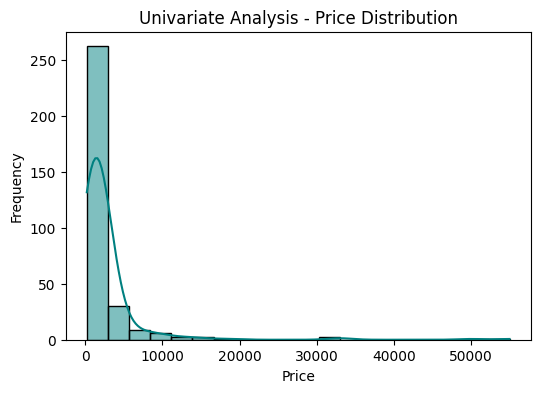

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df['ProductPrice'], bins=20, kde=True, color='teal')
plt.title("Univariate Analysis - Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

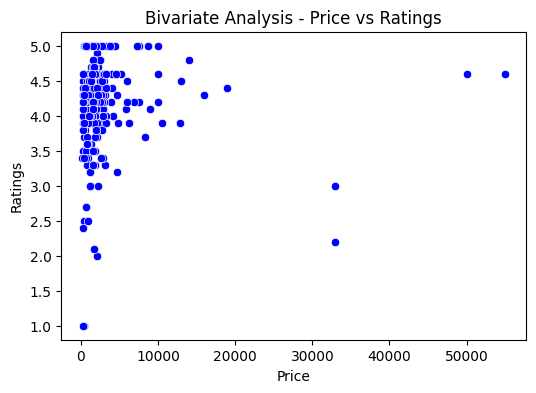

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='ProductPrice', y='ProductRating', data=df, color='blue')
plt.title("Bivariate Analysis - Price vs Ratings")
plt.xlabel("Price")
plt.ylabel("Ratings")
plt.show()

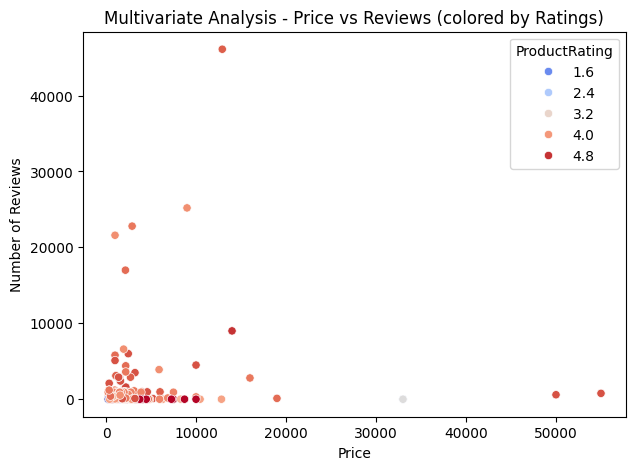

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='ProductPrice', y='Reviews', hue='ProductRating', data=df, palette='coolwarm')
plt.title("Multivariate Analysis - Price vs Reviews (colored by Ratings)")
plt.xlabel("Price")
plt.ylabel("Number of Reviews")
plt.show()

In [ ]:
!pip install sqlalchemy

In [ ]:
import sqlite3
conn = sqlite3.connect('playstation_.db')
cursor = conn.cursor()

In [ ]:
df.to_sql("playstation__data",conn,index=False,if_exists='replace')

316

In [ ]:
conn.close()

In [ ]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///playstation_.db')
df= pd.read_sql('select * from playstation__data',con=engine)

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
print(df.columns)
features = df[['ProductPrice', 'ProductRating', 'Reviews']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
print(scaled_df.head())

Index(['ProductName', 'ProductPrice', 'ProductRating', 'Reviews'], dtype='object')
   ProductPrice  ProductRating   Reviews
0      9.963558       0.655462 -0.041002
1      9.012460       0.655462 -0.091426
2     -0.308256       0.315353  1.336336
3      3.114477       0.315353 -0.221596
4      0.622865      -0.194809  0.815655


In [ ]:
from sklearn.cluster import KMeans
kmeans= KMeans(n_clusters = 3,random_state=42 )
df['cluster']=kmeans.fit_predict(scaled_features)

In [ ]:
df['cluster'].value_counts()

,count
cluster,
0,256
1,56
2,4


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'ProductRating')

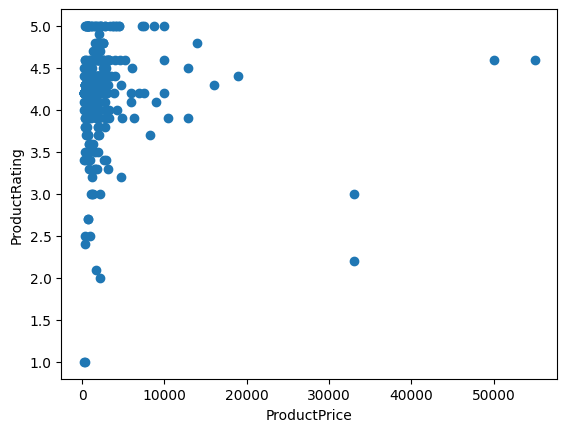

In [ ]:
plt.scatter(df.ProductPrice,df['ProductRating'])
plt.xlabel('ProductPrice')
plt.ylabel('ProductRating')

**UNSUPERVISED LEARNING**

Choose a suitable clustering algorithm (e.g., K-meane).

Experiment with different numbers of clusters (n) to find the optimal grouping.

Add a new column to your dataset to indicate each product's cluster membership.

Goal: Use clustering (K-Means) to group similar products.

In [ ]:
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(df[['ProductPrice','ProductRating']])
y_predicted

array([1, 1, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2,
       0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0,
       2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
df['cluster']= y_predicted
df.head()

,ProductName,ProductPrice,ProductRating,Reviews,cluster
0,Sony PlayStation5 Gaming Console (Slim),54989,4.6,774,1
1,Sony PlayStation®5 Digital Edition (slim) Cons...,49990,4.6,590,1
2,Rs.1000 Sony PlayStation Store Gift Card (Emai...,1000,4.4,5800,0
3,Sony PlayStation Portal Remote Player,18990,4.4,115,2
4,Sony DualSense Wireless Controller White (Play...,5894,4.1,3900,2


In [ ]:
km.cluster_centers_

array([[1.58429795e+03, 4.21198630e+00],
       [4.27397500e+04, 3.60000000e+00],
       [9.72050000e+03, 4.37500000e+00]])

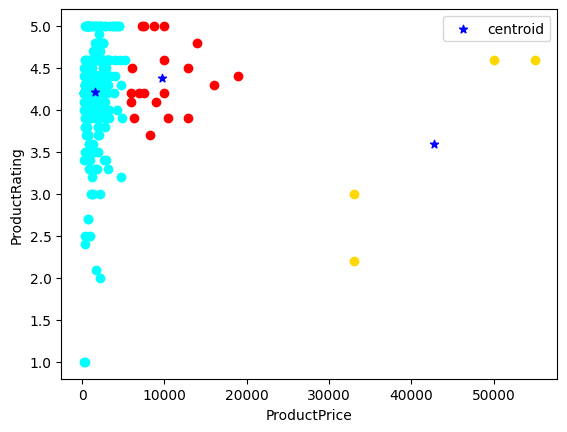

In [ ]:
df1 = df[df.cluster==0]
df2 = df[df.cluster==1]
df3 = df[df.cluster==2]
plt.scatter(df1.ProductPrice,df1['ProductRating'],color='aqua')
plt.scatter(df2.ProductPrice,df2['ProductRating'],color='gold')
plt.scatter(df3.ProductPrice,df3['ProductRating'],color='red')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='blue',marker='*',label='centroid')
plt.xlabel('ProductPrice')
plt.ylabel('ProductRating')
plt.legend()

In [ ]:
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df[['ProductPrice','ProductRating']])
    sse.append(km.inertia_)

In [ ]:
sse

[8729782262.311022,
 2208927438.4128222,
 1456446995.1419182,
 589610209.8243151,
 344642278.44110876,
 190141466.6215136,
 126551261.31563044,
 93874302.59709491,
 74213255.79016037]

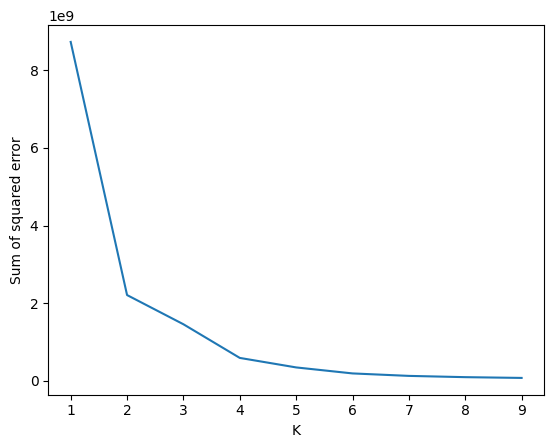

In [ ]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

**SUPERVISED LEARNING**


. Logistic Regression

. Support Vector Machine (SVM)

. k-Nearest Neighbors (k-NN)

. Random Forest

. XGBoost

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [ ]:
df['High_Rated'] = (df['ProductRating'] >= 4.0).astype(int)

In [ ]:
df['ProductRating'].unique()

array([4.6, 4.4, 4.1, 4. , 4.5, 3.3, 4.3, 3.2, 3.9, 4.2, 5. , 3.7, 2.2,
       3. , 4.7, 4.8, 3.8, 3.6, 3.5, 2. , 3.4, 2.7, 2.5, 1. , 4.9, 2.1,
       2.4])

In [ ]:
X = df[['ProductPrice', 'Reviews']]
y = df['High_Rated']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
def Algorithms(*models):

    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"\n🔹 Model: {model.__class__.__name__}")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Algorithms(
    LogisticRegression(random_state=42, max_iter=1000),
    SVC(),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=42, n_estimators=200),
    XGBClassifier())


🔹 Model: LogisticRegression
Accuracy: 0.796875

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.80      1.00      0.89        51

    accuracy                           0.80        64
   macro avg       0.40      0.50      0.44        64
weighted avg       0.64      0.80      0.71        64


🔹 Model: SVC
Accuracy: 0.796875

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.80      1.00      0.89        51

    accuracy                           0.80        64
   macro avg       0.40      0.50      0.44        64
weighted avg       0.64      0.80      0.71        64


🔹 Model: KNeighborsClassifier
Accuracy: 0.78125

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.23      0.30        13
           1       0.82      0.9

**EVALUATE MODEL PERFORMANCE**

                 Model  Accuracy  Precision    Recall  F1 Score
3        Random Forest  0.828125   0.833259  0.828125  0.830457
4              XGBoost  0.796875   0.770368  0.796875  0.777439
2                  KNN  0.781250   0.744126  0.781250  0.754514
0  Logistic Regression  0.796875   0.635010  0.796875  0.706793
1                  SVM  0.796875   0.635010  0.796875  0.706793
BEST MODEL: Random Forest


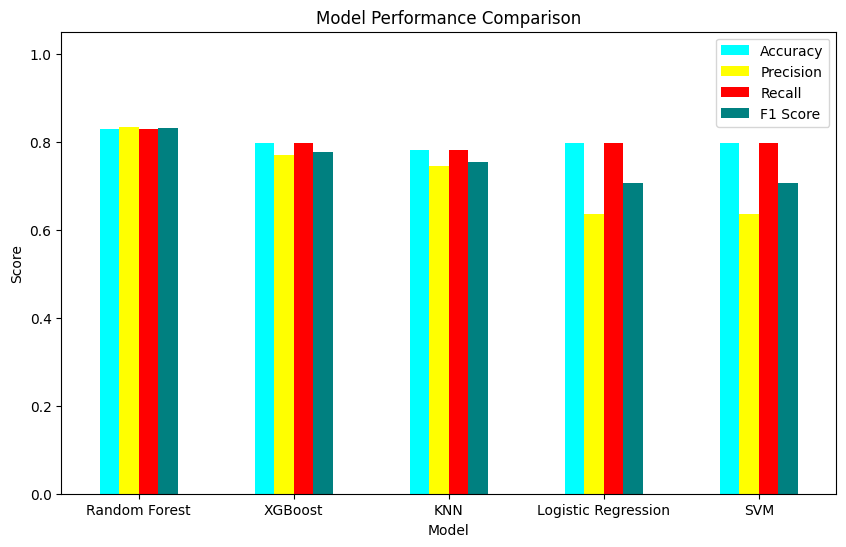

In [ ]:
models = {"Logistic Regression": LogisticRegression(),
                          "SVM": SVC(),
                          "KNN": KNeighborsClassifier(),
                "Random Forest": RandomForestClassifier(),
                      "XGBoost": XGBClassifier()}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({ "Model": name,
                  "Accuracy": accuracy_score(y_test, y_pred),
                 "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
                    "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
                  "F1 Score": f1_score(y_test, y_pred, average="weighted", zero_division=0)})

comparison_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print(comparison_df)
print("BEST MODEL:", comparison_df.iloc[0]["Model"])

colors = ["aqua","yellow","red","teal"]

comparison_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1 Score"]].plot(kind="bar", figsize=(10,6), rot=0,  color=colors)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.show()


**HYPERPARAMTER TUNING**

Select the best-performing model (based on accuracy/F1-score).

Use GridSearchCV or RandomizedSearchCV to find the best parameters:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("✅ Best Parameters:", grid_search.best_params_)
print("✅ Best Accuracy:", grid_search.best_score_)

✅ Best Parameters: {'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
✅ Best Accuracy: 0.8136470588235294


In [ ]:
df

,ProductName,ProductPrice,ProductRating,Reviews,cluster,High_Rated
0,Sony PlayStation5 Gaming Console (Slim),54989,4.6,774,1,1
1,Sony PlayStation®5 Digital Edition (slim) Cons...,49990,4.6,590,1,1
2,Rs.1000 Sony PlayStation Store Gift Card (Emai...,1000,4.4,5800,0,1
3,Sony PlayStation Portal Remote Player,18990,4.4,115,2,1
4,Sony DualSense Wireless Controller White (Play...,5894,4.1,3900,2,1
...,...,...,...,...,...,...
311,Dual Controller Stand – Universal Gamepad Hold...,389,3.9,5,0,0
312,Assassin's Creed Valhalla Drakkar Edition (Fre...,1565,4.1,539,0,1
313,GADGETS WRAP Printed Vinyl Decal Sticker Skin ...,246,4.2,924,0,1
314,Glitch | Ps5 Dust Cover | Covers For Playstati...,499,4.4,399,0,1
